# Import necessary libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install mplcyberpunk
!pip install -U efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.6 MB/s eta 0:00:00


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import mplcyberpunk
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Flatten, MaxPooling2D, Conv2D, Activation, GlobalMaxPooling2D

# Organize training, validation and test datasets with image augmentation

In [4]:
data_path = '/content/drive/MyDrive/Colab Notebooks/DATASET/image data'
fruit = 'strawberry'
batch_size = 32
img_height, img_width = 256, 256
input_shape = (img_height, img_width, 3)

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)


datagen = ImageDataGenerator(rescale = 1./255)

train_ds = train_datagen.flow_from_directory(data_path + '/train/' + fruit, batch_size = batch_size, class_mode='sparse', target_size=(img_height, img_width))

validation_ds = datagen.flow_from_directory(data_path + '/validation/' + fruit, batch_size = batch_size, class_mode='sparse', target_size=(img_height, img_width), shuffle = False)

test_ds = datagen.flow_from_directory(data_path + '/test/' + fruit, target_size=(img_height, img_width), batch_size=batch_size, class_mode='sparse', subset='training', shuffle = False)
# print(train_ds.class_indices)
# print(train_ds.n)

Found 1129 images belonging to 2 classes.
Found 281 images belonging to 2 classes.
Found 155 images belonging to 2 classes.


# Import EfficientNetB0 model and add some layers to it

In [5]:
import efficientnet.keras as efn
base_model = efn.EfficientNetB0(input_shape = input_shape, include_top = False, weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
#avoid overfitting
model.add(Dropout(0.2))
# Set NUMBER_OF_CLASSES to the number of your final predictions.
model.add(Dense(train_ds.num_classes, activation="softmax", name="fc_out"))
# train_ds.num_classes is number of output class in this fruit


from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
#ModelCheckpoint callback saves a model at some interval.
# filepath="saved_models/weights-improvement-{epoch:02d}-{val_sparse_categorical_accuracy:.2f}.hdf5" #File name includes epoch and validation
# VGG19_filepath = 'vgg_19_'+'-saved-model-{epoch:02d}-acc-{val_sparse_categorical_accuracy:.2f}.hdf5'# accuracy.
#Use Mode = max for accuracy and min for loss.
# checkpoint = ModelCheckpoint('./Model.ckpt', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
# checkpoint = ModelCheckpoint(filepath, monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
filepath = fruit + '_EffNetB0_'+'-saved-model-{epoch:02d}-acc-{val_sparse_categorical_accuracy:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True, mode='max')

#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
early_stop = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=10, verbose=1 , mode = "max")
#This callback will stop the training when there is no improvement in
# the validation loss for three consecutive epochs.

#CSVLogger logs epoch, acc, loss, val_acc, val_loss
log_csv = CSVLogger('my_logs.csv', separator=',', append=False)

callbacks_list = [checkpoint, log_csv, early_stop]

# history = model.fit(train_ds, epochs=5, batch_size=batch_size, validation_data=val_ds, callbacks=[callbacks_list]) #old mine
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer='adam',
    metrics=["sparse_categorical_accuracy"]
)
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=30,
    steps_per_epoch = train_ds.n // batch_size,
    validation_steps = validation_ds.n // batch_size,
    verbose=1,
    use_multiprocessing=True,
    workers=4,
    callbacks=[callbacks_list]
)# resnet_history = base_model.fit(train_ds, validation_data = validation_ds, steps_per_epoch = 100, epochs = 27)      #website
model.summary()



model.save('modelLeafEffNetB0_'+fruit+'.h5')
file = open('./BaseModelWeights.txt', 'w')
for v in model.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')

file.close()

16804768/16804768 [==============================] - 0s 0us/step
Epoch 1/30
35/35 [==============================] - ETA: 0s - loss: 2.1585 - sparse_categorical_accuracy: 0.9526
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 1.00000, saving model to strawberry_EffNetB0_-saved-model-01-acc-1.00.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


35/35 [==============================] - 101s 2s/step - loss: 2.1585 - sparse_categorical_accuracy: 0.9526 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Epoch 2/30
35/35 [==============================] - ETA: 0s - loss: 0.3391 - sparse_categorical_accuracy: 0.9927
Epoch 2: val_sparse_categorical_accuracy did not improve from 1.00000
35/35 [==============================] - 24s 616ms/step - loss: 0.3391 - sparse_categorical_accuracy: 0.9927 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Epoch 3/30
35/35 [==============================] - ETA: 0s - loss: 0.0746 - sparse_categorical_accuracy: 0.9964
Epoch 3: val_sparse_categorical_accuracy did not improve from 1.00000
35/35 [==============================] - 32s 719ms/step - loss: 0.0746 - sparse_categorical_accuracy: 0.9964 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000
Epoch 4/30
35/35 [==============================] - ETA: 0s - loss: 0.1698 - sparse_categorical_accuracy: 0.9954
E

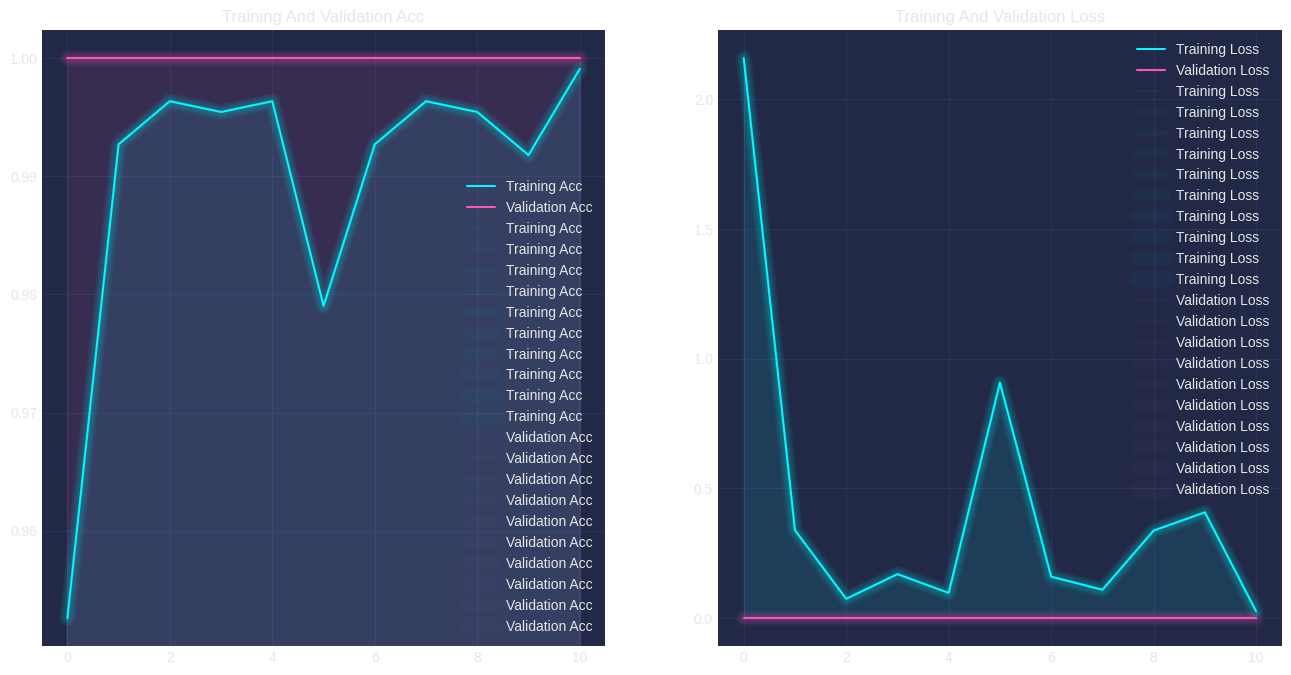

In [6]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.style.use('cyberpunk')
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Acc')
plt.plot(val_acc, label='Validation Acc')
plt.title('Training And Validation Acc')
mplcyberpunk.add_glow_effects()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training And Validation Loss')
mplcyberpunk.add_glow_effects()
plt.legend()
plt.show()

In [7]:
model.evaluate(test_ds)

5/5 [==============================] - 26s 6s/step - loss: 0.0000e+00 - sparse_categorical_accuracy: 1.0000


[0.0, 1.0]

# Compute confusion matrix and generate classification report

In [8]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# assume you have a trained model called 'model'

# predict the labels for the test set
y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)

# extract the true labels from the test set
y_true = test_ds.classes

# compute the confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred)

# print the confusion matrix
print('Confusion matrix:')
print(confusion_mat)

# compute the classification report
class_names = list(test_ds.class_indices.keys())
class_report = classification_report(y_true, y_pred, target_names=class_names)

# print the classification report
print('Classification report:')
print(class_report)

5/5 [==============================] - 2s 120ms/step
Confusion matrix:
[[ 45   0]
 [  0 110]]
Classification report:
              precision    recall  f1-score   support

     healthy       1.00      1.00      1.00        45
 leaf scorch       1.00      1.00      1.00       110

    accuracy                           1.00       155
   macro avg       1.00      1.00      1.00       155
weighted avg       1.00      1.00      1.00       155



In [9]:
def predict_batch(X, Y, labels, model,figSize=(15, 15), dpi=75, cells_per_col=4, color=None):
    """
    This function plots a batch of the raw images with its true targets

    Parameters
    ----------
    X : (np.ndarray)
        batch of images to classify and plot
    class_indices: (dict)
        dictionary for index and name of each class, ie: 0 : 'apple scab'
    Y : (np.ndarray)
        batch of predicted labels

    figSize : (tuple)
        initialize the figure size

    dpi : (int)
        increase/decrease zoom of subplots

    cells_per_col : (int)
        max number of columns in the figure

    color : (str)
        change the color map of the image plot
    """

    m = len(X)  # length of the batch
    img_size = X[0].shape
    fig = plt.figure(figsize=figSize, dpi=dpi)
    # labels = class_indices
    # labels = dict((v,k) for k,v in labels.items())
    predictions = [labels[k] for k in Y]
    for i in range(m):  # for each img in the batch
        class_id = Y[i] # get the current image true value
        axis = fig.add_subplot(round(m/cells_per_col), cells_per_col, i+1) # display a grid of subplots
        axis.imshow(X[i], cmap=color)                   # plot each image
        axis.set_title("Actual: " + labels[Y[i]] + "; Predicted: "+labels[np.argmax(model.predict(np.array( [X[i],] ) ))])    # set the title of the img with the ture value
        axis.set_xticks(np.linspace(0, img_size[1], 5)) # scale the x-axis to match the image width
        axis.set_yticks(np.linspace(0, img_size[0], 5)) # scale the y-axis to match the image height
        axis.grid()
    fig.tight_layout(pad=1)
    plt.show()

In [10]:
# test_datagen = ImageDataGenerator(rescale = 1./255,
#                                    rotation_range=180,
#                                    shear_range = 0.5,
#                                    zoom_range = 0.6,
#                                    horizontal_flip = True)

test_ds = datagen.flow_from_directory(data_path + '/test/' + fruit, target_size=(img_height, img_width), batch_size=batch_size,
                                      class_mode='sparse', shuffle = True)

Found 155 images belonging to 2 classes.


1/1 [==============================] - 0s 36ms/step


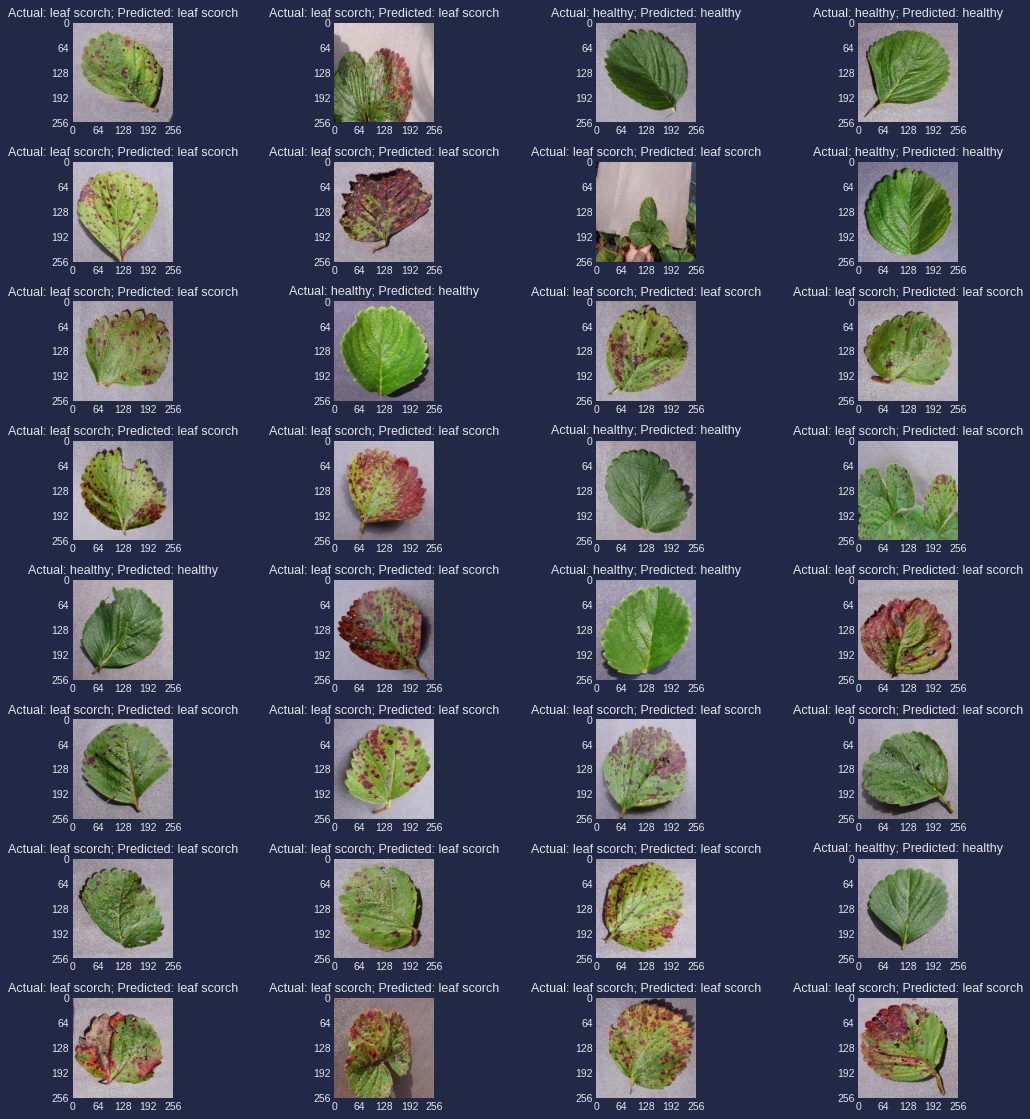

sparse_categorical_accuracy: 100.00%


In [11]:
X_test, y_test = next(test_ds)
import numpy as np
labels = train_ds.class_indices
labels = dict((v,k) for k,v in labels.items())
# labels = {0: 'apple scab', 1: 'black rot', 2: 'cedar apple rust', 3: 'healthy'}
# random_ids = np.random.randint(0, 32 , 16)
predict_batch(X_test,  y_test, labels, model)
scores = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))